In [97]:
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
from pylab import plot, show, xlabel, ylabel, legend, semilogy,semilogx, grid, xlim, ylim, title,savefig, minorticks_on, figtext

import csv
import pandas as pd
from astropy import modeling
from scipy import optimize
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.integrate import quad
import datetime
from datetime import timedelta
from datetime import datetime

In [98]:
def gaussian(x, amplitude, mean, stddev,offset): #make a funciton that returns a gaussian
    return amplitude * np.exp(-((x - mean)/ stddev)**2/ 2)+offset
def integrand(x, mean, stddev,offset):
    return np.exp(-((x - mean)/ stddev)**2/ 2)+offset

Import Thomson data

In [99]:
shotnr=[28925,28928,28935,28939,28943,28947,28950]
def TS(expnum):
    filename=('Thomson_2021-06-10_#' + str(shotnr[expnum-1]) + '.txt')
    df = pd.read_csv(filename, delimiter = "\t", skiprows=5, warn_bad_lines=True, error_bad_lines=False) #remove lines that do not have 5 columns 
    data_columns=df.columns.values
    num_df = (df.drop(data_columns, axis=1).join(df[data_columns].apply(pd.to_numeric, errors='coerce'))) #remove the lines that are not fully numerical
    num_df = num_df[num_df[data_columns].notnull().all(axis=1)] #remove the lines that are not fully numerical
    num_df.index=list(range(0, len(num_df))) #sets the indec to start at 0 and increase by 1, row number

    # There are 3 Thomson measurements per exp so we need to see which times correspond to thebegining and end of each exp. 
    difference = num_df.diff(axis=0) #difference between two consecutive rows
    t12=num_df[difference.iloc[:,0]<0].index.values #the 1st column is the position which per measurement always increases, so if the diff is negative it means we have a new measurement 
    T1=num_df.iloc[0:t12[0]]
    T2=num_df.iloc[t12[0]:t12[1]]
    T3=num_df.iloc[t12[1]:len(num_df)]

    popt, pcov = optimize.curve_fit(gaussian, T3.iloc[:,0], T3.iloc[:,2]) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    popt_n, pcov_n = optimize.curve_fit(gaussian, T3.iloc[:,0], (T3.iloc[:,1]*1e-18)) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    return T3,popt,popt_n

Plot the first TS data

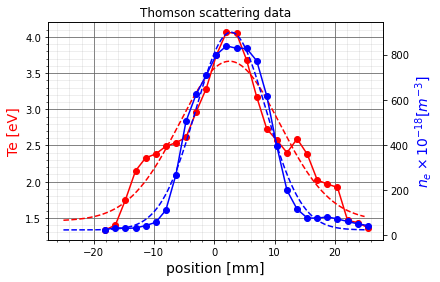

In [116]:
x=np.arange(-25,25,0.1)
T3,popt,popt_n=TS(6)
fig,ax = plt.subplots()
ax.plot(T3.iloc[:,0],T3.iloc[:,2],'-or')
ax.plot(x, gaussian(x, *popt),'--r')
xlabel('position [mm]', fontsize=14)
ylabel('Te [eV]', color="red",fontsize=14)

grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)

ax2=ax.twinx()
ax2.plot(T3.iloc[:,0],T3.iloc[:,1]*1e-18,'-ob')
ax2.set_ylabel(r'$n_e \times 10^{-18} [ m^{-3}]$', color="blue",fontsize=14)
ax2.plot(x, gaussian(x, *popt_n),'--b')
title('Thomson scattering data')
#savefig('TS.png', dpi=1000)
plt.show()

Calometry calibration

In [101]:
cp=4200 #J
E=97320 #J/kg/K

data=pd.read_csv("temp.csv", delimiter='|', skiprows=1)   #Import calorimetry calibration data
data["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in data["Date/Time"]] # converts the time strings to readable datetime
time_int=data["Date/Time"]-data["Date/Time"][0]
time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
data = data.assign(t=time_int2) # assign the interval found in seconds as a column
data.Value=data.Value-data.Value.iloc[0:37].mean()
Tint=np.trapz(data.Value,data.t) #integrated delta temperature
mflow=E/(Tint*cp) #[kg/s]


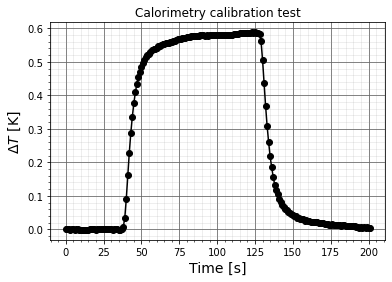

In [102]:
plot(data.t,data.Value, 'ko-')
xlabel('Time [s]', fontsize=14)
ylabel('$\Delta T$ [K]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Calorimetry calibration test')
show()

In [117]:
data=pd.read_csv("calorimetry.csv", delimiter='|', skiprows=1)   #Import the experimental data
data["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in data["Date/Time"]] # converts the time strings to readable datetime
tstart=["2021-06-10 11:21","2021-06-10 11:44","2021-06-10 13:47","2021-06-10 14:12","2021-06-10 14:38","2021-06-10 14:53","2021-06-10 15:07"]
tstart = [datetime.strptime(x,'%Y-%m-%d %H:%M') for x in tstart] # converts the time strings to readable datetime
tend=[tstart[x]+timedelta(seconds=20*60) for x in range(len(tstart))] # sets the end of the experiments 20 minutes after the start

def calo(expnum):
    ind1=data[data["Date/Time"]>tstart[expnum-1]].index[expnum-1] #index start time
    ind2=data[data["Date/Time"]<tend[expnum-1]].index[-1] #index end time
    tint=data["Date/Time"].iloc[ind1:ind2] # Indexes of the complete experiment
    offset=data.Value.iloc[ind1-100:ind1].mean() # Takes the average of the 100 sec before the experiment as a base value 

    #Set expi to the values beloning to this experiment
    expi = pd.DataFrame(columns = ["time", "temp"])
    expi=expi.assign(time=data["Date/Time"].iloc[ind1:ind2])
    expi=expi.assign(temp=data.Value.iloc[ind1:ind2]-offset) 
    time_int=expi.time-expi.time.iloc[0]
    time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
    expi = expi.assign(t=time_int2) # assign the interval found in seconds as a column
    Tint=np.trapz(expi.temp,expi.t)
    E=mflow*(Tint*cp) #[J]
    P=E/420  # [W] divided by 7 min(the length of the experiment)
    return expi, P

In [104]:
tstart[3]

datetime.datetime(2021, 6, 10, 14, 12)

In [120]:
ind1=data[data["Date/Time"]>tstart[expnum-1]].index[expnum-1] #index start time
ind2=data[data["Date/Time"]<tend[expnum-1]].index[-1] #index end time
tint=data["Date/Time"].iloc[ind1:ind2] # Indexes of the complete experiment
offset=data.Value.iloc[ind1-100:ind1].mean() # Takes the average of the 100 sec before the experiment as a base value 

#Set expi to the values beloning to this experiment
expi = pd.DataFrame(columns = ["time", "temp"])
expi=expi.assign(time=data["Date/Time"].iloc[ind1:ind2])
expi=expi.assign(temp=data.Value.iloc[ind1:ind2]-offset) 
time_int=expi.time-expi.time.iloc[0]
time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
expi = expi.assign(t=time_int2) # assign the interval found in seconds as a column
Tint=np.trapz(expi.temp,expi.t)
E=mflow*(Tint*cp) #[J]
P=E/420  # [W] divided by 7 min(the length of the experiment)

Plot calorimeter data experiment 1

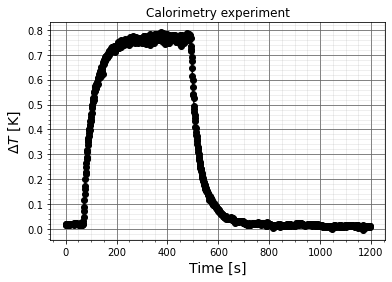

In [118]:
plot(calo(3)[0].t,calo(3)[0].temp, 'ko-')
xlabel('Time [s]', fontsize=14)
ylabel('$\Delta T$ [K]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Calorimetry experiment')
show()


In [107]:
def q(expnum): # [x]=mm, [q]=kW
    global x
    T3,popt,popt_n=TS(expnum)
    I = quad(integrand, -20, 25, (popt[1], popt[2], 0) ) #assume offset is zero, there is no heat flux on the edges
    expi, P=calo(expnum)
    A=P/I[0]
    q=gaussian(x, A,popt[1], popt[2], 0)
    return q


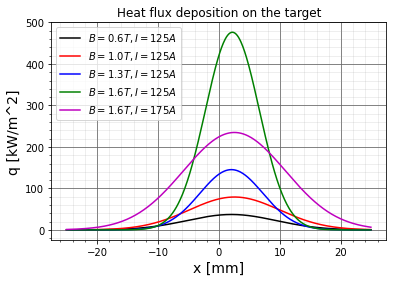

In [121]:
plot(x, q(2), 'k-',label='$B=0.6T,I=125A$')
plot(x, q(3), 'r-',label='$B=1.0T,I=125A$')
plot(x, q(4), 'b-',label='$B=1.3T,I=125A$')
plot(x, q(5), 'g-',label='$B=1.6T,I=125A$')
plot(x, q(6), 'm-',label='$B=1.6T,I=175A$')
#plot(x, q(7), 'y-',label='$B=1.6T,I=200A$')

xlabel('x [mm]', fontsize=14)
ylabel('q [kW/m^2]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Heat flux deposition on the target')
legend()
show()
